### Train the 3D CNN on the dataset

In [1]:
from keras.utils import np_utils
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.losses import binary_crossentropy
from keras.optimizers import Adadelta, SGD
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
from keras.models import Model
import cv2
import time
import os
import numpy as np
import keras
import h5py
import numpy as np
from keras import regularizers
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K
from keras.models import load_model
import keras
import tensorflow as tf


np.random.seed(1)

# Print version
print("Keras Version", keras.__version__)
print("Tensorflow Version", tf.__version__)

# Helpers functions

def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)


# Define paths
base_path = os.path.abspath("./") # Your root directory
dataset_path = os.path.join(base_path, "dataset") # Your dataset folder
model_path = os.path.join(base_path, "models")
log_path = os.path.join(base_path, "logs")

# Name your experiment
experiment_name = "siz"

create_directory(log_path)
create_directory(log_path+"/"+experiment_name)

Using TensorFlow backend.


Keras Version 2.3.1
Tensorflow Version 2.0.0


In [2]:
from sklearn.model_selection import train_test_split

raw = np.load('{}/x_train_sss.npy'.format(dataset_path))
labels = np.load('{}/y_train_clef.npy'.format(dataset_path))

print(raw.shape, labels.shape)

X_train, X_test, y_train, y_test = train_test_split(raw, labels, test_size=0.2, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# If not cross validation, do this 60 20 20 split
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
#print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(218, 128, 128, 64) (218, 2)
(174, 128, 128, 64) (174, 2) (44, 128, 128, 64) (44, 2)


In [3]:
y = np.array([np.argmax(x) for x in y_train])
print(np.count_nonzero(y == 1), np.count_nonzero(y == 0))

# For 60 20 20 split
# train 65, 65
# val 22, 22
# test 20, 24


def expand_dims(val):
    val_exp = np.expand_dims(val, axis=4)
    return val_exp

X_train = expand_dims(X_train)
#X_val = expand_dims(X_val)
X_test = expand_dims(X_test)
print(X_train.shape, X_test.shape)

87 87
(174, 128, 128, 64, 1) (44, 128, 128, 64, 1)


In [4]:
# Callbacks
weights_path = "{}/{}.h5".format(log_path+"/"+experiment_name, "best_model")
checkpointer = ModelCheckpoint(filepath=weights_path, verbose=1, monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-8, mode='auto') # new_lr = lr * factor
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=8, mode='auto', restore_best_weights=True)
csv_logger = CSVLogger('{}/training.csv'.format(log_path+"/"+experiment_name))

# Define class weights for imbalacned data
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(np.argmax(y_train, axis=1)), np.argmax(y_train, axis=1))
print("Class weights:", class_weights)


def awesome_3D_network():
    
    filter_size = 32
    depth = 64
    input_layer = Input((128, 128, depth, 1)) # 1 is just dummy dimension good for nothing 
    
    conv_layer1 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(input_layer)
    pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer1)

    pooling_layer1 = BatchNormalization()(pooling_layer1)  
    conv_layer2 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
    pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)
    pooling_layer2 = BatchNormalization()(pooling_layer2)
    conv_layer3 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
    pooling_layer3 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer3)
    pooling_layer3 = BatchNormalization()(pooling_layer3)
    conv_layer4 = Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu')(pooling_layer3)
    pooling_layer4 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)
    pooling_layer4 = BatchNormalization()(pooling_layer4)
    conv_layer5 = Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu')(pooling_layer4)
    pooling_layer5 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer5)
    
    pooling_layer9 = BatchNormalization()(pooling_layer5)
    flatten_layer = Flatten()(pooling_layer9)

    #dense_layer1 = Dense(units=1028, activation='relu')(flatten_layer)
    #dense_layer1 = Dropout(0.4)(dense_layer1)
    
    #dense_layer2 = Dense(units=1028, activation='relu')(flatten_layer)
    #dense_layer2 = Dropout(0.4)(dense_layer2)
    
    dense_layer3 = Dense(units=512, activation='relu')(flatten_layer)
    dense_layer3 = Dropout(0.4)(dense_layer3)

    dense_layer4 = Dense(units=256, activation='relu')(dense_layer3)
    dense_layer4 = Dropout(0.4)(dense_layer3)
  
    output_layer = Dense(units=2, activation='softmax')(dense_layer4)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='mae', optimizer=SGD(lr=1e-06, momentum=0.99, decay=0.0, nesterov=False), metrics=['acc']) 
    
    return model

model = None
model = awesome_3D_network()
model.summary()


Class weights: [1. 1.]
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 64, 1)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 

In [5]:
# kfold cross validation
# https://www.kaggle.com/sharifamit19/data-augmentation-cross-validation-ensemble

# Cross validation

from sklearn.model_selection import StratifiedKFold

# define 10-fold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
print(kfold)

data = X_train
labels = np.array([np.argmax(x) for x in y_train])

print(data.shape, labels.shape)

# Store scores here
cross_val_scores = []


# Calculate the starting time    
start_time = time.time()

# Run folds
for i, (train, test) in enumerate(kfold.split(data, labels)):
    
    print("Fold - {}".format(i), data[train].shape, labels[train].shape, data[test].shape, labels[test].shape)
    
    # Clearing the NN.
    #K.clear_session()
    model = None 
    
    # Calculate the starting time    
    start_time = time.time()

    # Create the model
    model = awesome_3D_network()
    
    # One hot :convert class vectors to binary class matrices
    y_train_cv = keras.utils.to_categorical(labels[train], 2)
    y_val_cv = keras.utils.to_categorical(labels[test], 2)
    
    # Set callbacks
    cb = None #[csv_logger, early_stopping, reduce_lr, checkpointer]
    cw = None #class_weights

    # Train
    h=model.fit(x=data[train],     
                y=y_train_cv,
                validation_data=(data[test], y_val_cv), 
                batch_size=2, 
                epochs=100, 
                verbose=1,
                class_weight = cw,
                callbacks=cb,
                shuffle=False,
                )

    # Evaluate

    #score = model.evaluate(data[test], y_val_cv, verbose=0)
    #loss, acc = score[0], score[1]

    # Validation predictions stored here
    y_pred_cv = []

    # Iterate over images in validation
    for img in data[test]:
        img = np.expand_dims(img, axis=0)  # rank 4 tensor for prediction
        y = model.predict(img)
        y_pred_cv.append(y[:][0])

    # Numpy
    y_pred_cv = np.array(y_pred_cv)
    
    # Convert ground truth to column values
    y_val_cv_flat = np.argmax(y_val_cv, axis=1)
    # Get labels from predictions
    y_pred_cv_flat = np.array([np.argmax(pred) for pred in y_pred_cv]) # y_pred[1] -> probability for class 1 

    # Accuracy
    acc = accuracy_score(y_val_cv_flat, y_pred_cv_flat) * 100
    print("Fold {} accuracy :".format(i), acc)

    cross_val_scores.append(acc)

    
end_time = time.time()

print(start_time, end_time)
print("--- Time taken to train : %s minutes ---" % ((end_time - start_time)//60))
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))

StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
(174, 128, 128, 64, 1) (174,)
Fold - 0 (139, 128, 128, 64, 1) (139,) (35, 128, 128, 64, 1) (35,)
Train on 139 samples, validate on 35 samples
Epoch 1/100
139/139 [==============================] - 9s 64ms/step - loss: 0.4622 - acc: 0.5827 - val_loss: 0.5017 - val_acc: 0.4857
Epoch 2/100
139/139 [==============================] - 6s 40ms/step - loss: 0.4291 - acc: 0.5899 - val_loss: 0.5062 - val_acc: 0.4857
Epoch 3/100
139/139 [==============================] - 6s 41ms/step - loss: 0.4223 - acc: 0.5971 - val_loss: 0.5097 - val_acc: 0.4857
Epoch 4/100
139/139 [==============================] - 6s 42ms/step - loss: 0.4337 - acc: 0.5755 - val_loss: 0.5118 - val_acc: 0.4857
Epoch 5/100
139/139 [==============================] - 6s 42ms/step - loss: 0.3784 - acc: 0.6475 - val_loss: 0.5129 - val_acc: 0.4857
Epoch 6/100
139/139 [==============================] - 6s 42ms/step - loss: 0.3773 - acc: 0.6403 - val_loss: 0.5134 - val_acc: 0.4

#### Mean and standard deviation

In [7]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cross_val_scores), np.std(cross_val_scores)))

62.64% (+/- 5.73%)


In [8]:
#SIZ: 62.03% (+/- 4.15%) #62.64% (+/- 5.73%)
#SSS: 61.48% (+/- 2.50%)
#ESS 

In [9]:
'''
cb = None #[csv_logger, early_stopping, reduce_lr, checkpointer]
cw = None #class_weights

# Calculate the starting time    
start_time = time.time()

# One hot :convert class vectors to binary class matrices
y_train_cv = keras.utils.to_categorical(y_train, 2)
y_val_cv = keras.utils.to_categorical(y_val, 2)

# Train
h=model.fit(x=X_train,     
            y=y_train,
            validation_data=(X_val, y_val), 
            batch_size=2, 
            epochs=100, 
            verbose=1,
            class_weight = cw,
            callbacks=cb,
            shuffle=False,
            )

end_time = time.time()
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))
'''

'\ncb = None #[csv_logger, early_stopping, reduce_lr, checkpointer]\ncw = None #class_weights\n\n# Calculate the starting time    \nstart_time = time.time()\n\n# One hot :convert class vectors to binary class matrices\ny_train_cv = keras.utils.to_categorical(y_train, 2)\ny_val_cv = keras.utils.to_categorical(y_val, 2)\n\n# Train\nh=model.fit(x=X_train,     \n            y=y_train,\n            validation_data=(X_val, y_val), \n            batch_size=2, \n            epochs=100, \n            verbose=1,\n            class_weight = cw,\n            callbacks=cb,\n            shuffle=False,\n            )\n\nend_time = time.time()\nprint("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))\n'

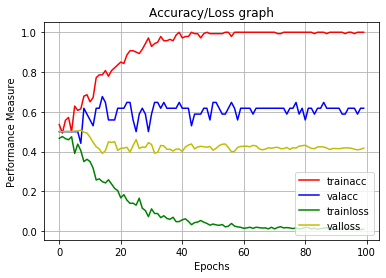

Done training and logging!


In [10]:
# Plot and save accuravy loss graphs together
def plot_loss_accu_all(history):
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(len(loss))
    
    plt.plot(epochs, acc, 'r')
    plt.plot(epochs, val_acc, 'b')
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Accuracy/Loss graph')
    
    plt.ylabel('Performance Measure')
    plt.xlabel('Epochs')
    
    plt.legend(['trainacc', 'valacc', 'trainloss', 'valloss'], loc='lower right', fontsize=10)
    plt.grid(True)
    plt.savefig('{}/{}.png'.format(log_path+"/"+experiment_name, "trainval_acc_loss"), dpi=500)
    plt.show()


# Plot and save accuravy loss graphs individually
def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    #plt.title('Training and validation loss')
    plt.ylabel('Loss %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid(True)
    #plt.savefig('{}/{}_loss.jpg'.format(output_path, EXP_NAME), dpi=100)
    #plt.savefig('{}/{}_loss.pdf'.format(output_path, EXP_NAME), dpi=300)
    plt.show()
    
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    #plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy %')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid(True)
    #plt.savefig('{}/{}_acc.jpg'.format(output_path, EXP_NAME), dpi=100)
    #plt.savefig('{}/{}_acc.pdf'.format(output_path, EXP_NAME), dpi=300)
    plt.show()

plot_loss_accu_all(model.history)
print("Done training and logging!")

In [11]:
model.save("{}/{}.h5".format(log_path+"/"+experiment_name, experiment_name))

In [12]:
#model = None
#model = load_model("{}/best_model.h5".format(model_path))

#score = model.evaluate(X_test, y_test, verbose=1)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

In [13]:
# Inference on hold out test set

y_pred = []

for img in X_test:
  img = np.expand_dims(img, axis=0)  # rank 4 tensor for prediction
  y = model.predict(img)
  y_pred.append(y[:][0])

y_pred = np.array(y_pred)
y_pred.shape

(44, 2)

In [14]:
# Convert ground truth to column values
y_test_flat = np.argmax(y_test, axis=1)
print("After flattening ground truth: ", y_test_flat.shape)

# Get labels from predictions
y_pred_flat = np.array([np.argmax(pred) for pred in y_pred]) # y_pred[1] -> probability for class 1 
print("Binarize probability values: ", y_pred_flat.shape)


# Accuracy

acc = accuracy_score(y_test_flat, y_pred_flat) * 100
print("Accuracy :", acc)


After flattening ground truth:  (44,)
Binarize probability values:  (44,)
Accuracy : 61.36363636363637


In [15]:
# SIZ: 63.63
# SSS: 59.09
# ESS:

In [16]:
# Classification report
from sklearn.metrics import confusion_matrix, classification_report

confusion_mtx = confusion_matrix(y_test_flat, y_pred_flat) 
print(confusion_mtx)
target_names = ['0', '1']
print(classification_report(y_test_flat, y_pred_flat, target_names=target_names))

[[12 12]
 [ 5 15]]
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        24
           1       0.56      0.75      0.64        20

    accuracy                           0.61        44
   macro avg       0.63      0.62      0.61        44
weighted avg       0.64      0.61      0.61        44



In [17]:
'''
SIZ:
[[12 12]
 [ 4 16]]
              precision    recall  f1-score   support

           0       0.75      0.50      0.60        24
           1       0.57      0.80      0.67        20

    accuracy                           0.64        44
   macro avg       0.66      0.65      0.63        44
weighted avg       0.67      0.64      0.63        44

SSS:

[[14 10]
 [ 8 12]]
              precision    recall  f1-score   support

           0       0.64      0.58      0.61        24
           1       0.55      0.60      0.57        20

    accuracy                           0.59        44
   macro avg       0.59      0.59      0.59        44
weighted avg       0.60      0.59      0.59        44



'''

'\nSIZ:\n[[12 12]\n [ 4 16]]\n              precision    recall  f1-score   support\n\n           0       0.75      0.50      0.60        24\n           1       0.57      0.80      0.67        20\n\n    accuracy                           0.64        44\n   macro avg       0.66      0.65      0.63        44\nweighted avg       0.67      0.64      0.63        44\n\nSSS:\n\n[[14 10]\n [ 8 12]]\n              precision    recall  f1-score   support\n\n           0       0.64      0.58      0.61        24\n           1       0.55      0.60      0.57        20\n\n    accuracy                           0.59        44\n   macro avg       0.59      0.59      0.59        44\nweighted avg       0.60      0.59      0.59        44\n\n\n\n'

In [18]:
from sklearn.metrics import roc_auc_score
print('Area under ROC curve : ', roc_auc_score(y_test, y_pred) *100 )

# sss 64.99
# ess 
# siz 64.58

Area under ROC curve :  65.83333333333333


Area under the ROC curve for positive class: 0.6583333333333333


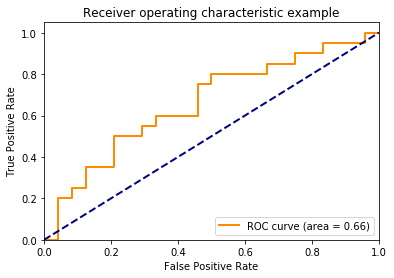

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Compute micro-average ROC curve and ROC area
cls = 1 # class name
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#print(roc_auc)
print("Area under the ROC curve for positive class:", roc_auc[1])


plt.figure()
lw = 2 # line width
plt.plot(fpr[cls], tpr[cls], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[cls])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('{}/{}.png'.format(log_path+"/"+experiment_name, "roc"), dpi=500)
plt.show()

In [20]:
# Helpers
import pickle 

def save_obj(obj, name):
    with open('{}'.format(log_path+"/") + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):
    with open('{}'.format(log_path+"/") + name + '.pkl', 'rb') as f:
        return pickle.load(f)

#https://github.com/hasibzunair/MelaNet/blob/master/isic2016_scripts/EDA.ipynb

# Save AUCROC for plotting
ascore = {}
ascore["fpr"] = fpr[cls]
ascore["tpr"] = tpr[cls]
ascore["roc_auc"] = roc_auc[cls]
save_obj(ascore, experiment_name)

type(fpr[cls]), roc_auc[cls] 

(numpy.ndarray, 0.6583333333333333)

### Inference on ImageCLEF test set

In [ ]:
model = None
model = load_model("{}/best_model.h5".format(model_path))
model.summary()

In [ ]:
x_test = expand_dims(x_test)

In [ ]:
res = []
for i in x_test:
    i = np.expand_dims(i, axis=0)
    y_pred = model.predict(i)
    res.append(y_pred)
    #print(i.shape)

In [ ]:
res = np.array(res)
res.shape

In [ ]:
res[:2]

In [ ]:
res

In [ ]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd

dt = pd.read_csv('{}/TestSet_metaData.csv'.format(dataset_path))
dt.head()

In [ ]:
patient_names = dt['Filename'].values
len(patient_names)

names = []

for name in patient_names:
    names.append(name[:-7])

names[:5]

probab = []

for p in res:
    # probability of HIGH severity as required to make submission
    probab.append(p[0][1])
    
probab[:5]

In [ ]:
for n, p in zip(names, probab):
    print(n, p)

In [ ]:
with open('{}/submission.txt'.format(dataset_path), 'w') as f:
    for n, p in zip(names, probab):
        print(n,",", p)
        f.write(str(n))
        f.write(",")
        f.write(str(p))
        f.write("\n")
        
f.close()